# Phoneme Embedding Using PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm

import re
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint

In [7]:
text = open("data/combilex_rpc.dct")
textSamples=[['$']+phonemes.split(' ')[1:]+['£'] for phonemes in (text.read().split('\n'))]

tokenSet = [tokens for tokens in textSamples if len(tokens)>4]

vocab = list(set([token for tokens in tokenSet for token in tokens]))
print(vocab)

['sh', 'th', 'v', 'w', 'ea', 'ih', 'aw', 'ua', 'dh', 'ch', 'ng', 'jh', 'uh', 'g', 'ia', 'ax', 'er', 'k', 'uw', 'z', 'eh', 't', 'ae', 'ao', 'l', 'b', 'd', 's', '£', 'en', '$', 'ah', 'em', 'zh', 'iy', 'hh', 'r', 'aa', 'f', 'y', 'm', 'ay', 'p', 'el', 'oy', 'oh', 'ey', 'n', 'ow']


In [8]:
def phone2int(graph):
    return vocab.index(graph)
    
def int2phone(index):
    return vocab[index]

def int2vec(integer):
    vec=np.zeros(len(vocab))
    vec[integer]=1
    return vec

def phone2vec(graph):
    return (int2vec(phone2int(graph)))

def vec2phone(vec):
    return (int2phone(np.argmax(vec)))

In [9]:
windowSize = 2
tokens = [tokenSet for tokenSet in tokens if len(tokenSet)>=6]
print(len(tokens))

147333


In [10]:
x_data = torch.empty(size=(1,2,len(vocab)))
y_data = torch.empty(size=(1,4))

for word in tokens:
    wc = len(word)
    for graph_i in range(2,wc-3): 
        data_sample = torch.tensor([phone2vec(word[graph_i]), phone2vec(word[graph_i+1])]).unsqueeze(0).float()
        x_data = torch.cat([x_data,data_sample])
        
        label_sample = torch.tensor([phone2int(word[graph_i-2]), phone2int(word[graph_i-1]), 
                                         phone2int(word[graph_i+2]), phone2int(word[graph_i+3])]).unsqueeze(0).float()
        y_data = torch.cat([y_data,label_sample])
        
x_data=x_data[1:,:,:]
y_data=y_data[1:,:]

KeyboardInterrupt: 

In [11]:
x_data.shape
y_data.shape

torch.Size([37632, 4])

## PyTorch

### Encoder

In [12]:
class Encoder(nn.Module):
    def __init__(self,grapheme_shape,hidden_units,embedding_units):
        super(Encoder,self).__init__()
        self.word_shape = grapheme_shape
        self.hidden_units = hidden_units
        self.embedding_units = embedding_units
        
        self.weights_1 = nn.Parameter(torch.empty(size=(hidden_units, grapheme_shape), requires_grad=True))
        nn.init.normal_(self.weights_1)
        
        self.weights_2 = nn.Parameter(torch.empty(size=(embedding_units, hidden_units), requires_grad=True))
        nn.init.normal_(self.weights_2)
        
        self.bias1 = nn.Parameter(torch.zeros(hidden_units), requires_grad=True)
        self.bias2 = nn.Parameter(torch.zeros(embedding_units), requires_grad=True)

    def forward(self,inputs):
        out = F.linear(inputs, self.weights_1, self.bias1)
        out = nn.ReLU().forward(out)
        out = F.linear(out, self.weights_2,self.bias2)
        out = nn.ReLU().forward(out)
        return out
    

        

### Phone2Vec

In [13]:
class Decoder(nn.Module):
    def __init__(self,embedding_units,layer_1_n,grapheme_shape,encoder):
        super(Decoder,self).__init__()
        self.e = encoder
        self.embedding_units=embedding_units
        self.layer_1_n = layer_1_n

        self.weights_layer1 = nn.Parameter(torch.empty(size=(self.layer_1_n, self.embedding_units*2), requires_grad=True))
        nn.init.normal_(self.weights_layer1)
        self.bias_layer1 = nn.Parameter(torch.zeros(layer_1_n), requires_grad=True)

        self.weights_output2l = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output2l)
        self.bias2l = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output1l = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output1l)
        self.bias1l = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output1r = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output1r)
        self.bias1r = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
        
        self.weights_output2r = nn.Parameter(torch.empty(size=(grapheme_shape, self.layer_1_n), requires_grad=True))
        nn.init.normal_(self.weights_output2r)
        self.bias2r = nn.Parameter(torch.zeros(grapheme_shape), requires_grad=True)
      
    def forward(self,inputs):
        embedding1 = self.e.forward(inputs[:,0])
        embedding2 = self.e.forward(inputs[:,1])

        out = torch.cat((embedding1,embedding2),dim=1)

        out = nn.ReLU().forward(F.linear(out, self.weights_layer1, self.bias_layer1))
        
        out2l = nn.ReLU().forward(F.linear(out, self.weights_output2l, self.bias2l))
        out1l = nn.ReLU().forward(F.linear(out, self.weights_output1l, self.bias1l))
        out1r = nn.ReLU().forward(F.linear(out, self.weights_output1r, self.bias1r))
        out2r = nn.ReLU().forward(F.linear(out, self.weights_output2r, self.bias2r))
        
        out = torch.stack((out2l,out1l,out1r,out2r),dim=1)
        return out
    
    def encode(self,inputs):
        return self.e.forward(inputs)


In [14]:
train_ratio = 0.80
batch_size = 256

trn_n = int(x_data.shape[0] * 0.8)
batches = (int(trn_n/batch_size))

x_trn = x_data[:trn_n,:,:].clone()
y_trn = y_data[:trn_n,:].clone()

x_val = x_data[trn_n:,:,:].clone()
y_val = y_data[trn_n:,:].clone()

In [15]:
metric_dict = {'losses_trn': [],'losses_val':[]} 
encoder =  Encoder(grapheme_shape=len(vocab),hidden_units=10,embedding_units=5)
decoder = Decoder(embedding_units=5,layer_1_n=15,grapheme_shape=len(vocab),encoder=encoder)
optimizer = optim.Adam(decoder.parameters(), amsgrad=False, weight_decay=0.0)

trn_loss = nn.NLLLoss()
val_loss = nn.NLLLoss()

for epoch in range(100):
    print(epoch)
    epoch_trn_loss_sum = 0
    for batch in (range(batches)):
        x_batch = x_trn[batch_size*batch:batch_size*(batch+1)]
        y_batch = y_trn[batch_size*batch:batch_size*(batch+1)]

        out = decoder.forward(x_batch).transpose(1,2)
        log_softmax = F.log_softmax(out, dim=1)
        
        NLL_Loss = trn_loss(log_softmax,y_batch.long()) 
        optimizer.zero_grad()
        NLL_Loss.backward()
        optimizer.step()
        epoch_trn_loss_sum += NLL_Loss.item()
        
    out_val = decoder.forward(x_val).transpose(1,2)
    log_val_softmax = F.log_softmax(out_val, dim=1)
    NLL_val_loss = trn_loss(log_val_softmax, y_val.long())
    
    epoch_trn_loss = epoch_trn_loss_sum/batches
    print(NLL_val_loss.item())
    print(epoch_trn_loss)
   # print("Val: "+str(val_loss.item()))
    metric_dict['losses_trn'].append(NLL_Loss.item())
    metric_dict['losses_val'].append(epoch_trn_loss)

0
6.411762237548828
9.392645522060556
1
4.488015651702881
5.2305031923147345
2
3.9501452445983887
4.200196370100364
3
3.7475039958953857
3.850683102240929
4
3.651995897293091
3.7196502400259686
5
3.579296588897705
3.636720068434365
6
3.512345314025879
3.5663952318012204
7
3.4478306770324707
3.4996690261058316
8
3.3877949714660645
3.4381225374009876
9
3.330578327178955
3.379075900102273
10
3.279200792312622
3.323369704760038
11
3.2402164936065674
3.277661847253131
12
3.213019609451294
3.2436768621461005
13
3.1917943954467773
3.2186528046925864
14
3.17050838470459
3.1971313912644344
15
3.15549635887146
3.179540835894071
16
3.1442811489105225
3.166631034296802
17
3.1369881629943848
3.1575811602111554
18
3.1318674087524414
3.1514824312976284
19
3.1287331581115723
3.1473527667868852
20
3.1263997554779053
3.144438007957915
21
3.1242294311523438
3.142169748616015
22
3.1230716705322266
3.1404639676085906
23
3.122265577316284
3.1389366255866156
24
3.121246814727783
3.1376763510907817
25
3.12100

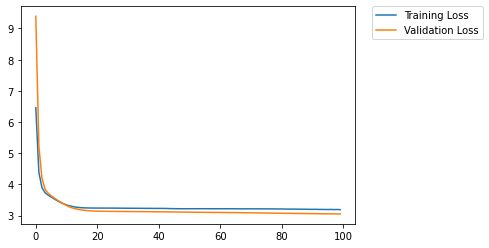

In [16]:
plt.plot(metric_dict['losses_trn'],label = "Training Loss")
plt.plot(metric_dict['losses_val'],label = "Validation Loss")
#plt.legend([val, train], ['Val Loss', 'Training Loss'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

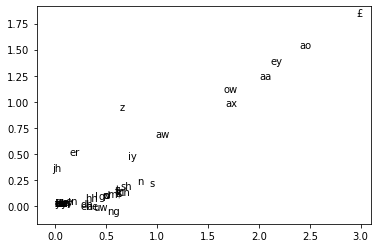

In [75]:
embeddings = np.zeros(shape=(len(vocab),5))

i=0
for phoneme in vocab:
    test = torch.from_numpy(phone2vec(phoneme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1

embedding_means = embeddings.mean(axis=0)
embedding_std = embeddings.std(axis=0)
norm_embeddings = (embeddings-embedding_means)/embedding_std

    
covariance_matrix = np.cov(norm_embeddings.T)
v,w = np.linalg.eig(covariance_matrix)

idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

variance_explained = []
for i in v:
     variance_explained.append((i/sum(v))*100)
        
red_Vecs = w[0:2,:]

low_d_embed = (embeddings @ red_Vecs.T)

#plt.scatter(x=low_d_embed[:,0],y=low_d_embed[:,1])

x=low_d_embed[:,0]
y=low_d_embed[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y,color='white')
 
for i, txt in enumerate(vocab):
    ax.annotate(txt, (x[i], y[i]))

In [20]:
n=randint(0,x_trn.shape[0])

input = x_trn[n,:,:].unsqueeze(0)
output = y_trn[n,:]

out=decoder.forward(input).transpose(1,2)
log_softmax = -F.log_softmax(out, dim=1)

p=(log_softmax.argmin(dim=1).detach().numpy()[0])
o=(output.int().numpy())

numpy_input = input.int().detach().numpy()[0]
inp_ind = (numpy_input.argmax(axis=1))
inp_let = [vocab[i] for i in inp_ind]
pred = [vocab[i] for i in p]
outp = [vocab[i] for i in o]
print(inp_let)
print("Prediction: "+' '.join(pred[0:2])+" "+' '.join(inp_let)+" "+' '.join(pred[2:]))
print("Target:     "+' '.join(outp[0:2])+" "+' '.join(inp_let)+" "+' '.join(outp[2:]))

['d', 'ax']
Prediction: $ ae d ax z £
Target:     m ih d ax z £


In [39]:
embeddings = np.zeros(shape=(len(vocab),5))

i=0
for grapheme in vocab:
    test = torch.from_numpy(phone2vec(grapheme)).float()
    embedding = decoder.encode(test).detach().numpy()
    embeddings[i,:]=embedding
    i+=1
    
l=0
for e in (embeddings):
    dists=(np.square(embeddings-e).sum(axis=1))
    nearest_idx=(np.argsort(dists)[1])
    print("Nearest neighbour of "+vocab[l]+" : "+vocab[nearest_idx])
    l+=1
    

Nearest neighbour of th : t
Nearest neighbour of s : n
Nearest neighbour of m : v
Nearest neighbour of d : p
Nearest neighbour of z : er
Nearest neighbour of ih : ay
Nearest neighbour of p : d
Nearest neighbour of ow : ax
Nearest neighbour of ng : dh
Nearest neighbour of em : ay
Nearest neighbour of oy : el
Nearest neighbour of ua : ay
Nearest neighbour of t : sh
Nearest neighbour of b : ay
Nearest neighbour of v : d
Nearest neighbour of er : iy
Nearest neighbour of y : ay
Nearest neighbour of ax : ow
Nearest neighbour of aa : ey
Nearest neighbour of eh : ae
Nearest neighbour of aw : iy
Nearest neighbour of ea : ay
Nearest neighbour of uh : ay
Nearest neighbour of iy : aw
Nearest neighbour of w : oh
Nearest neighbour of oh : ay
Nearest neighbour of l : g
Nearest neighbour of hh : l
Nearest neighbour of zh : ay
Nearest neighbour of k : $
Nearest neighbour of ao : ey
Nearest neighbour of f : ay
Nearest neighbour of ch : k
Nearest neighbour of dh : hh
Nearest neighbour of ey : aa
Nearest 

Experiment with graphemes on dictionary instead
Balance the classes - weight for each letter, estimate over training data (dataset dependent) weighting tensor put into loss function
Generate realistic looking words that aren't real words